In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Lucas\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import de dados

In [172]:
fires = pd.read_csv('./data/database_fires.csv')

In [114]:
fires.shape

(251767, 14)

In [173]:
respostas = pd.read_csv('./data/respostas.csv')

## Feature Engineering

### Fix Feature de temperaturas

In [174]:
# Dropar a temp_cond_media por ter alta correlacao com outras features

fires = fires.drop(columns = ['temp_comp_med'])
respostas = respostas.drop(columns = ['temp_comp_med'])

# Adicionar feature de delta_temp

fires['delta_temp'] = fires['temp_max'] - fires['temp_min']
respostas['delta_temp'] = respostas['temp_max'] - respostas['temp_min']

In [176]:
# Célula para ajustar ordem de colunas
fires = fires[['id', 'estado', 'estacao', 'data', 'precipitacao', 
               'temp_max','temp_min', 'insolacao', 'evaporacao_piche', 
               'umidade_rel_med', 'vel_vento_med', 'altitude', 'delta_temp', 'fires']]

respostas = respostas[['id', 'estado', 'estacao', 'data', 'precipitacao', 
               'temp_max','temp_min', 'insolacao', 'evaporacao_piche', 
               'umidade_rel_med', 'vel_vento_med', 'altitude', 'delta_temp']]

In [45]:
fires.head()

,id,estacao,precipitacao,temp_max,temp_min,insolacao,evaporacao_piche,umidade_rel_med,vel_vento_med,altitude,delta_temp,ano,mes,dia,lat,long,fires
0,1,50484,NaN,31.4,NaN,2.3,NaN,96.0,0.00000,170.0,NaN,2016,1,1,-8.77,-70.55,0
1,2,50484,0.0,32.5,23.3,4.4,NaN,95.0,0.51444,170.0,9.2,2016,1,2,-8.77,-70.55,0
2,3,50484,35.2,30.5,24.0,0.6,NaN,97.0,0.51444,170.0,6.5,2016,1,3,-8.77,-70.55,0
3,4,50484,60.2,31.7,22.3,2.0,NaN,96.0,0.00000,170.0,9.4,2016,1,4,-8.77,-70.55,0
4,5,50484,28.4,28.5,23.0,0.1,NaN,95.0,0.00000,170.0,5.5,2016,1,5,-8.77,-70.55,0


### Treating miss data

In [42]:
import missingno as msno

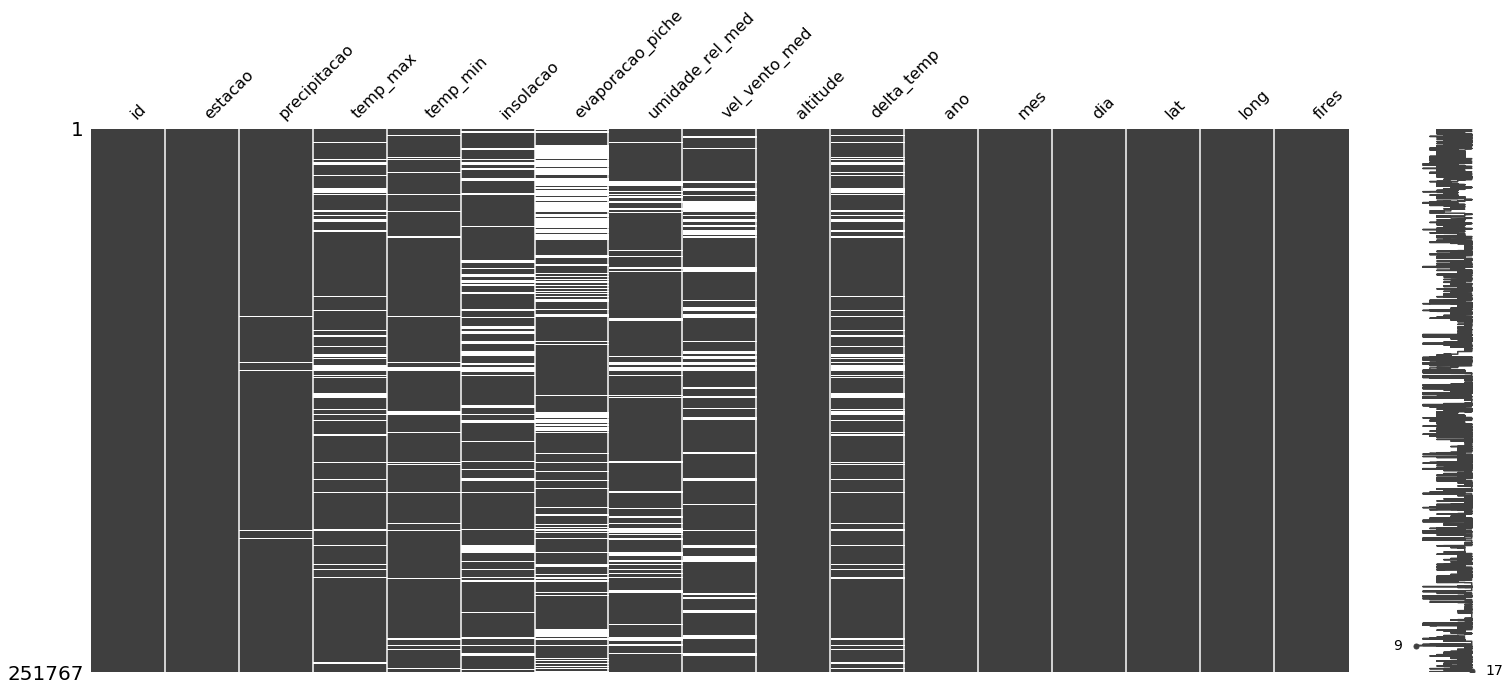

In [43]:
msno.matrix(fires)

In [50]:
# Tentativa de tratar NA na coluna de evaporacao_piche
trata_evap = fires[['id', 'evaporacao_piche', 'fires']]
trata_evap = trata_evap.dropna()

In [54]:
evap_0 = trata_evap.loc[trata_evap['fires'] == 0]
evap_1 = trata_evap.loc[trata_evap['fires'] == 1]

In [63]:
print(f'Média de evaporacao_piche: {evap_0["evaporacao_piche"].mean()} -- {evap_1["evaporacao_piche"].mean()}')
print(f'Std de evaporacao_piche: {evap_0["evaporacao_piche"].std()} -- {evap_1["evaporacao_piche"].std()}')
print(f'Mediana de evaporacao_piche: {evap_0["evaporacao_piche"].median()} -- {evap_1["evaporacao_piche"].median()}')

Média de evaporacao_piche: 4.034045169861426 -- 6.136099933291731
Std de evaporacao_piche: 3.1442728620997165 -- 3.7929661457980366
Mediana de evaporacao_piche: 3.2 -- 5.2


In [177]:
na_0 = (fires.loc[(fires['evaporacao_piche'].isna()) & (fires['fires'] == 0)])
na_0 = na_0[['id', 'evaporacao_piche']]
na_0['evaporacao_piche'] = 4 # média calculada acima

na_1 = (fires.loc[(fires['evaporacao_piche'].isna()) & (fires['fires'] == 1)])
na_1 = na_1[['id', 'evaporacao_piche']]
na_1['evaporacao_piche'] = 6 # média calculada acima

na_0 = na_0.append(na_1)

fires = fires.merge(na_0, how = 'left', left_on = 'id', right_on = 'id')

fires['evaporacao_piche'] = fires.apply(lambda row: row['evaporacao_piche_x'] if (row['evaporacao_piche_x'] >= 0) else row['evaporacao_piche_y'], axis = 1)

fires = fires.drop(columns = ['evaporacao_piche_x', 'evaporacao_piche_y'])

### Fix feature de datas

Transformei a coluna de data em outras duas:
 - dia_ano: é uma coluna type Timestamp (pra ser contínuo) com dia e mês da linha mas tudo no mesmo ano para pegar efeitos de sazonalidade
 - ano: ano da linha pq pode ser que um ano seja mais propício a ter incêndios que outro

In [25]:
# fires['dia_ano'] = fires['data'].apply(lambda row: pd.to_datetime(row[:-5] + '/2000', format = '%d/%m/%Y'))
# respostas['dia_ano'] = respostas['data'].apply(lambda row: pd.to_datetime(row[:-5] + '/2000', format = '%d/%m/%Y'))

In [179]:
fires['dia'] = fires['data'].map(lambda x: int(x[:2]))
respostas['dia'] = respostas['data'].map(lambda x: int(x[:2]))


fires['mes'] = fires['data'].map(lambda x: int(x[3:5]))
respostas['mes'] = respostas['data'].map(lambda x: int(x[3:5]))


fires['ano'] = fires['data'].map(lambda x: int(x[-4:]))
respostas['ano'] = respostas['data'].map(lambda x: int(x[-4:]))

# fires = fires.drop(columns = ['data'])
# respostas = respostas.drop(columns = ['data'])

In [186]:
# Célula para ajustar ordem de colunas
fires = fires[['id', 'estacao', 'precipitacao', 
               'temp_max','temp_min', 'insolacao', 'evaporacao_piche', 
               'umidade_rel_med', 'vel_vento_med', 'altitude', 'delta_temp', 'ano', 'mes', 'dia', 'lat', 'long','fires']]

respostas = respostas[['id', 'estacao', 'precipitacao', 
               'temp_max','temp_min', 'insolacao', 'evaporacao_piche', 
               'umidade_rel_med', 'vel_vento_med', 'altitude', 'delta_temp', 'ano', 'mes', 'dia', 'lat', 'long']]

In [187]:
fires.tail()

,id,estacao,precipitacao,temp_max,temp_min,insolacao,evaporacao_piche,umidade_rel_med,vel_vento_med,altitude,delta_temp,ano,mes,dia,lat,long,fires
251762,251763,77437,0.0,33.4,23.2,9.0,4.0,58.25,0.00000,603.59,10.2,2019,5,23,-10.25,-48.25,0
251763,251764,77437,0.0,33.3,22.1,8.6,4.0,63.75,0.34296,603.59,11.2,2019,5,24,-10.25,-48.25,0
251764,251765,77437,0.0,32.6,21.6,6.9,4.0,65.50,0.00000,603.59,11.0,2019,5,25,-10.25,-48.25,0
251765,251766,77437,0.0,34.0,22.6,7.9,4.0,57.00,0.00000,603.59,11.4,2019,5,26,-10.25,-48.25,0
251766,251767,77437,0.0,33.3,23.7,9.9,4.0,54.25,0.34296,603.59,9.6,2019,5,27,-10.25,-48.25,0


### Create feature de estado

Encode básico (one-hot) para a coluna de estado. Criei a feature região, que indica a macro-região a qual o estado pertence.

In [29]:
# One-hot enconde com drop_first = True para remover dependencia de variáveis
respostas = pd.get_dummies(respostas,prefix=['estado'], drop_first=True)
fires = pd.get_dummies(fires,prefix=['estado'], drop_first=True)

Encode de estado baseado em lat long média dos estados

In [185]:
fires['lat'] = fires['estado'].apply(lambda row: dict_estados_lat_long[row][0])
respostas['lat'] = respostas['estado'].apply(lambda row: dict_estados_lat_long[row][0])

In [184]:
fires['long'] = fires['estado'].apply(lambda row: dict_estados_lat_long[row][1])
respostas['long'] = respostas['estado'].apply(lambda row: dict_estados_lat_long[row][1])

In [181]:
# Feature região
dict_estados_lat_long = {
    'AC': [ -8.77, -70.55]
  , 'AL': [ -9.71, -35.73]
  , 'AM': [ -3.07, -61.66]
  , 'AP': [  1.41, -51.77]
  , 'BA': [-12.96, -38.51]
  , 'CE': [ -3.71, -38.54]
  , 'DF': [-15.83, -47.86]
  , 'ES': [-19.19, -40.34]
  , 'GO': [-16.64, -49.31]
  , 'MA': [ -2.55, -44.30]
  , 'MT': [-12.64, -55.42]
  , 'MS': [-20.51, -54.54]
  , 'MG': [-18.10, -44.38]
  , 'PA': [ -5.53, -52.29]
  , 'PB': [ -7.06, -35.55]
  , 'PR': [-24.89, -51.55]
  , 'PE': [ -8.28, -35.07]
  , 'PI': [ -8.28, -43.68]
  , 'RJ': [-22.84, -43.15]
  , 'RN': [ -5.22, -36.52]
  , 'RO': [-11.22, -62.80]
  , 'RS': [-30.01, -51.22]
  , 'RR': [  1.89, -61.22]
  , 'SC': [-27.33, -49.44]
  , 'SE': [-10.90, -37.07]
  , 'SP': [-23.55, -46.64]
  , 'TO': [-10.25, -48.25]
}

### Fix (?) feature de estacao

Ainda não entendi muito bem essa feature, então dropei ela

In [30]:
fires = fires.drop(columns = ['estacao'])
respostas = respostas.drop(columns = ['estacao'])

## Modelagem

### Modelo de ensemble de árvores usando XGBoost API

In [188]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [15]:
# Dataframe não contendo as variáveis categóricas ainda não tratadas (id, estacao, dia_ano). Dia_ano estou tendo problemas, teoricamente é numérica.
dados_modelo = fires.drop(columns = ['id', 'dia_ano'])

In [50]:
y = pd.DataFrame(dados_modelo['fires'])
x = dados_modelo.drop(columns = ['fires'])

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.15)

In [58]:
param = {'eta': 0.2, 
         'max_depth': 4, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'

steps = 30

#Transformando o df em DMatrix por causa do XGBoost
train = xgb.DMatrix(X_train, label=Y_train)

model = xgb.train(param, train, steps)

In [53]:
# Saving the current model
model.save_model('./models/xgboost_0003.model')

#### Evaluating the current model

In [44]:
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('./models/xgboost_model.bin') 

array([0.12250785, 0.28831634, 0.11807205, ..., 0.28067452, 0.39013144,
       0.19767644], dtype=float32)

In [54]:
D_test = xgb.DMatrix(X_test, label=Y_test)

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))
print("AUC ROC = {}".format(roc_auc_score(Y_test, preds)))

Precision = 0.37119366626065775
Recall = 0.5
Accuracy = 0.7423873325213155
AUC ROC = 0.8154517179813044


C:\Users\Lucas\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Evaluating feature importance

<Figure size 1800x1800 with 0 Axes>

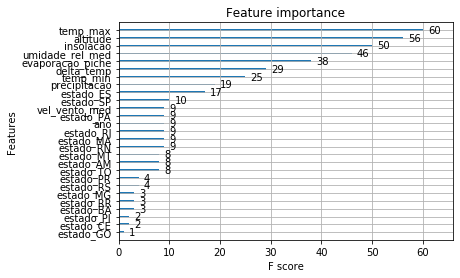

In [55]:
plt.figure(figsize=(25,25))
xgb.plot_importance(model)

### Modelo XGBoost using Scikit-learn

In [189]:
from xgboost import XGBClassifier

In [190]:
dados_modelo = fires.copy()

In [191]:
y = (dados_modelo['fires'])
x = dados_modelo.drop(columns = ['fires', 'id'])

In [192]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.01)

In [194]:
X_train.tail()

,estacao,precipitacao,temp_max,temp_min,insolacao,evaporacao_piche,umidade_rel_med,vel_vento_med,altitude,delta_temp,ano,mes,dia,lat,long
170570,19452,0.0,29.6,18.7,7.4,7.0,62.00,3.566667,370.46,10.9,2016,8,2,-8.28,-35.07
63099,73383,0.0,33.5,20.9,6.5,12.7,30.50,4.333333,1159.54,12.6,2017,10,22,-15.83,-47.86
86145,73147,7.4,37.0,23.5,7.4,7.5,69.00,1.600000,179.75,13.5,2016,11,11,-2.55,-44.30
105958,88782,0.0,25.2,15.5,8.6,3.9,59.75,NaN,1296.12,9.7,2016,9,10,-18.10,-44.38
41653,61065,0.0,32.0,21.2,3.9,4.0,77.75,1.714800,438.74,10.8,2017,12,8,-12.96,-38.51


In [195]:
model = XGBClassifier()

eval_set = [(X_train, Y_train), (X_test, Y_test)]
eval_metric = ["auc","error"]

%time model.fit(x, y, early_stopping_rounds = 40, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

Wall time: 22.8 s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [25]:
y_pred = model.predict(X_test)
round_predictions = [round(value) for value in y_pred]

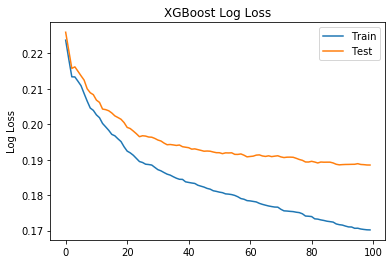

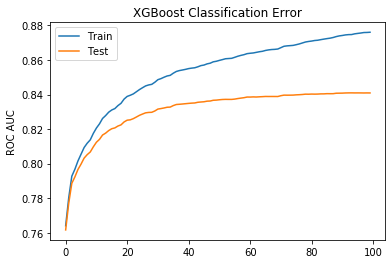

In [84]:
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot auc curve
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('ROC AUC')
plt.title('XGBoost Classification Error')
plt.show()

In [26]:
print("Precision = {}".format(precision_score(Y_test, round_predictions, average='macro')))
print("Recall = {}".format(recall_score(Y_test, round_predictions, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, round_predictions)))
print("AUC ROC = {}".format(roc_auc_score(Y_test, round_predictions)))

Precision = 0.7640758650333119
Recall = 0.7028033604013997
Accuracy = 0.8109610802223988
AUC ROC = 0.7028033604013996


In [27]:
respostas.head()

,id,estacao,precipitacao,temp_max,temp_min,insolacao,evaporacao_piche,umidade_rel_med,vel_vento_med,altitude,delta_temp,ano,mes,dia,lat,long
0,251768,50484,5.8,34.7,23.7,8.8,NaN,92.00,1.028880,170.0,11.0,2016,1,27,-8.77,-70.55
1,251769,50484,0.0,30.0,23.7,0.2,NaN,93.00,0.000000,170.0,6.3,2016,1,28,-8.77,-70.55
2,251770,50484,0.0,35.5,24.1,7.1,NaN,97.00,0.000000,170.0,11.4,2016,1,29,-8.77,-70.55
3,251771,50484,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,170.0,NaN,2016,8,5,-8.77,-70.55
4,251772,88948,0.0,34.7,21.6,8.3,2.0,86.75,0.666667,160.0,13.1,2019,5,28,-8.77,-70.55


In [198]:
respostas = respostas.drop(columns = ['id'])

In [196]:
respostas.head()

,id,estacao,precipitacao,temp_max,temp_min,insolacao,evaporacao_piche,umidade_rel_med,vel_vento_med,altitude,delta_temp,ano,mes,dia,lat,long
0,251768,50484,5.8,34.7,23.7,8.8,NaN,92.00,1.028880,170.0,11.0,2016,1,27,-8.77,-70.55
1,251769,50484,0.0,30.0,23.7,0.2,NaN,93.00,0.000000,170.0,6.3,2016,1,28,-8.77,-70.55
2,251770,50484,0.0,35.5,24.1,7.1,NaN,97.00,0.000000,170.0,11.4,2016,1,29,-8.77,-70.55
3,251771,50484,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,170.0,NaN,2016,8,5,-8.77,-70.55
4,251772,88948,0.0,34.7,21.6,8.3,2.0,86.75,0.666667,160.0,13.1,2019,5,28,-8.77,-70.55


In [199]:
submission = model.predict(respostas)

In [197]:
ids = respostas['id']

In [200]:
submission.shape

(44342,)

In [201]:
submission = pd.DataFrame(submission)
submission.columns = ['fires']

In [202]:
(pd.merge(ids, submission, left_index = True, right_index = True)).to_csv('./submissions/sub_05.csv', index = False)